<a href="https://colab.research.google.com/github/LeoLiaoJP/CS523-Dog-Recognition/blob/main/baseline_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CS523 — MobileNetV2 Baseline (30 Epochs) with **TFDS Stanford Dogs Download**

This notebook **downloads the Stanford Dogs dataset via TensorFlow Datasets (TFDS)**, exports it to an **ImageFolder** structure (`train/`, `val/`, `test`), and then trains a **MobileNetV2** baseline for **30 epochs**.  
Metrics: **Accuracy** and **Cross‑Entropy Loss**. Plots: **Loss** and **Accuracy** curves.


In [ ]:

# (Optional) If TFDS / TQDM / PIL are missing, uncomment the installs below.
# %pip -q install tensorflow-datasets tqdm pillow
# %pip -q install torch torchvision


In [ ]:

from pathlib import Path
import os, random, time, copy, json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ========= Config =========
DATA_ROOT = Path('./data/stanford_dogs_imagefolder')  # ImageFolder root that will be created by TFDS export
VAL_RATIO = 0.20     # fraction of official train per-class moved to val
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 30
SEED = 42
USE_AMP = True

# Training (simple & robust defaults)
HEAD_EPOCHS = 3            # warm-up head only
LR_BASE = 3e-4             # base LR
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS = 5          # cosine warmup
MIN_LR = 1e-6
LABEL_SMOOTH = 0.1

OUTPUT_DIR = Path('artifacts_mnv2_tfds')
FIG_DIR = Path('figures_mnv2_tfds')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(SEED)


Device: cuda


In [ ]:

# ========= Download via TFDS and export to ImageFolder =========
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import tensorflow_datasets as tfds

def export_tfds_to_imagefolder(data_root: Path, val_ratio: float = 0.20, seed: int = 42):
    data_root = Path(data_root)
    train_full_root = data_root / 'train_full'
    test_root = data_root / 'test'
    train_root = data_root / 'train'
    val_root = data_root / 'val'

    # Quick check: already exported?
    if (train_root.exists() and val_root.exists() and test_root.exists() and
        any(train_root.rglob('*.jpg')) and any(val_root.rglob('*.jpg')) and any(test_root.rglob('*.jpg'))):
        print('[Info] ImageFolder structure already present — skip TFDS export.')
        return

    print('[Step] Loading TFDS: stanford_dogs ...')
    ds_train = tfds.load('stanford_dogs', split='train', as_supervised=True)
    ds_test  = tfds.load('stanford_dogs', split='test',  as_supervised=True)
    info = tfds.builder('stanford_dogs').info
    class_names = info.features['label'].names

    def _export(ds, out_root: Path, split_name: str):
        out_root.mkdir(parents=True, exist_ok=True)
        counts = {cls: 0 for cls in class_names}
        for img, label in tqdm(tfds.as_numpy(ds), desc=f'Export {split_name}'):
            cls = class_names[int(label)]
            cls_dir = out_root / cls
            cls_dir.mkdir(parents=True, exist_ok=True)
            idx = counts[cls]
            Image.fromarray(img).save(cls_dir / f'{idx:08d}.jpg', quality=95)
            counts[cls] += 1
        return counts

    counts_train = _export(ds_train, train_full_root, 'train_full')
    counts_test  = _export(ds_test,  test_root,  'test')

    # Build per-class stratified val split from train_full
    print('[Step] Building per-class stratified val split ...')
    rng = random.Random(seed)
    train_root.mkdir(parents=True, exist_ok=True)
    val_root.mkdir(parents=True, exist_ok=True)

    for cls in tqdm(class_names, desc='Split train_full → {train, val}'):
        src_dir = train_full_root / cls
        imgs = sorted([p for p in src_dir.glob('*.jpg')])
        n = len(imgs)
        n_val = max(1, int(round(n * val_ratio)))
        rng.shuffle(imgs)
        val_imgs = imgs[:n_val]
        train_imgs = imgs[n_val:]
        (train_root / cls).mkdir(parents=True, exist_ok=True)
        (val_root / cls).mkdir(parents=True, exist_ok=True)
        for p in val_imgs:
            p.replace(val_root / cls / p.name)
        for p in train_imgs:
            p.replace(train_root / cls / p.name)

    print('[Done] TFDS export complete.')
    # Optionally, we could remove train_full to save space
    # import shutil; shutil.rmtree(train_full_root, ignore_errors=True)

# Run export (only if not already done)
export_tfds_to_imagefolder(DATA_ROOT, VAL_RATIO, SEED)


[Step] Loading TFDS: stanford_dogs ...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.HBRPOI_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.HBRPOI_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Export test: 100%|██████████| 8580/8580 [00:22<00:00, 380.72it/s]


[Step] Building per-class stratified val split ...


Split train_full → {train, val}: 100%|██████████| 120/120 [00:00<00:00, 298.34it/s]

[Done] TFDS export complete.


In [ ]:

# ========= Data pipeline =========
# Use ImageNet normalization (robust to torchvision version)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_dir = DATA_ROOT / 'train'
val_dir   = DATA_ROOT / 'val'
assert train_dir.is_dir() and val_dir.is_dir(), 'Dataset folders not found; please run the TFDS export cell.'

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
NUM_CLASSES = len(train_ds.classes)
print('Classes:', NUM_CLASSES)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dataloaders = {'train': train_loader, 'val': val_loader}


Classes: 120


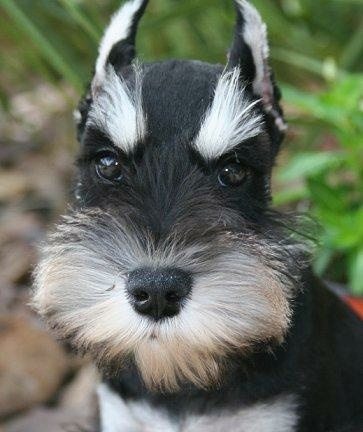

In [ ]:
from IPython.display import display; from PIL import Image; import random; p,_=random.choice(train_ds.samples); display(Image.open(p))

In [ ]:

# ========= Model =========
def create_mobilenet_v2(num_classes: int, prefer_pretrained: bool = True):
    try:
        from torchvision.models import MobileNet_V2_Weights
        weights = MobileNet_V2_Weights.DEFAULT if prefer_pretrained else None
        model = models.mobilenet_v2(weights=weights)
    except Exception:
        model = models.mobilenet_v2(pretrained=prefer_pretrained)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

model = create_mobilenet_v2(NUM_CLASSES, prefer_pretrained=True).to(device)
try:
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
except TypeError:
    criterion = nn.CrossEntropyLoss()
print('Trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 139MB/s]

Trainable params: 2377592


In [ ]:

# ========= Optimizer & Cosine scheduler (with warmup) =========
import math

def build_optimizer_and_scheduler(model, base_lr, weight_decay, warmup_epochs, total_epochs, min_lr):
    opt = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch + 1) / float(warmup_epochs)
        # cosine decay from base_lr to min_lr
        T = max(1, total_epochs - warmup_epochs)
        t = epoch - warmup_epochs
        cosine = 0.5 * (1 + math.cos(math.pi * t / T))
        return (min_lr / base_lr) + (1 - (min_lr / base_lr)) * cosine
    sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    return opt, sch

optimizer, scheduler = build_optimizer_and_scheduler(
    model, base_lr=LR_BASE, weight_decay=WEIGHT_DECAY,
    warmup_epochs=WARMUP_EPOCHS, total_epochs=EPOCHS, min_lr=MIN_LR
)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and device.type=='cuda')


/tmp/ipython-input-2595530435.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and device.type=='cuda')


In [ ]:

# ========= Train & evaluate =========
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(scaler is not None and scaler.is_enabled())):
            logits = model(x)
            loss = criterion(logits, y)
        if scaler is not None and scaler.is_enabled():
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return running_loss / total, 100.0 * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return running_loss / total, 100.0 * correct / total

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
best_val, best_epoch = 0.0, 0
best_state = copy.deepcopy(model.state_dict())
start = time.time()

# Two-stage: head warm-up then full fine-tune
for epoch in range(1, EPOCHS + 1):
    # head-only vs full
    if epoch == 1:
        for p in model.parameters(): p.requires_grad = False
        for p in model.classifier.parameters(): p.requires_grad = True
    if epoch == HEAD_EPOCHS + 1:
        for p in model.parameters(): p.requires_grad = True

    history['lr'].append(optimizer.param_groups[0]['lr'])
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device, scaler)
    val_loss, val_acc = evaluate(model, dataloaders['val'], criterion, device)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc);   history['val_acc'].append(val_acc)

    if val_acc > best_val:
        best_val, best_epoch = val_acc, epoch
        best_state = copy.deepcopy(model.state_dict())

    scheduler.step()

    print(f'Epoch {epoch:02d}/{EPOCHS} | LR {history["lr"][-1]:.6f} | '
          f'Train Loss {train_loss:.4f} Acc {train_acc:.2f}% | '
          f'Val Loss {val_loss:.4f} Acc {val_acc:.2f}%')

elapsed = time.time() - start
model.load_state_dict(best_state)
metrics = {
    'best_val_acc': best_val,
    'best_epoch': best_epoch,
    'final_train_acc': history['train_acc'][-1],
    'final_val_loss': history['val_loss'][-1],
    'elapsed_sec': elapsed,
}
print(f'Best Val Acc: {best_val:.2f}% (Epoch {best_epoch})')


/tmp/ipython-input-2169318852.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None and scaler.is_enabled())):


Epoch 01/30 | LR 0.000060 | Train Loss 4.6231 Acc 7.19% | Val Loss 4.4155 Acc 23.75%
Epoch 02/30 | LR 0.000120 | Train Loss 4.1379 Acc 33.75% | Val Loss 3.8349 Acc 49.67%
Epoch 03/30 | LR 0.000180 | Train Loss 3.5341 Acc 52.38% | Val Loss 3.2029 Acc 60.04%
Epoch 04/30 | LR 0.000240 | Train Loss 2.1256 Acc 65.33% | Val Loss 1.7596 Acc 72.46%
Epoch 05/30 | LR 0.000300 | Train Loss 1.6781 Acc 74.88% | Val Loss 1.6604 Acc 75.08%
Epoch 06/30 | LR 0.000300 | Train Loss 1.4680 Acc 82.28% | Val Loss 1.6409 Acc 74.83%
Epoch 07/30 | LR 0.000299 | Train Loss 1.3328 Acc 87.60% | Val Loss 1.6118 Acc 74.58%
Epoch 08/30 | LR 0.000295 | Train Loss 1.2499 Acc 90.49% | Val Loss 1.6190 Acc 75.21%
Epoch 09/30 | LR 0.000290 | Train Loss 1.1636 Acc 93.56% | Val Loss 1.6007 Acc 75.54%
Epoch 10/30 | LR 0.000282 | Train Loss 1.1106 Acc 95.27% | Val Loss 1.6185 Acc 74.00%
Epoch 11/30 | LR 0.000271 | Train Loss 1.0707 Acc 96.47% | Val Loss 1.6294 Acc 74.75%
Epoch 12/30 | LR 0.000259 | Train Loss 1.0303 Acc 97.46

In [ ]:
print(f"Best Validation Accuracy: {metrics['best_val_acc']:.2f}% (Epoch {metrics['best_epoch']}),  Final Training Accuracy: {metrics['final_train_acc']:.2f}%,  Final Validation Loss: {metrics['final_val_loss']:.4f},  Training Time: ~{metrics['elapsed_sec']/60:.1f} minutes")

Best Validation Accuracy: 77.33% (Epoch 30),  Final Training Accuracy: 99.88%,  Final Validation Loss: 1.5885,  Training Time: ~28.8 minutes


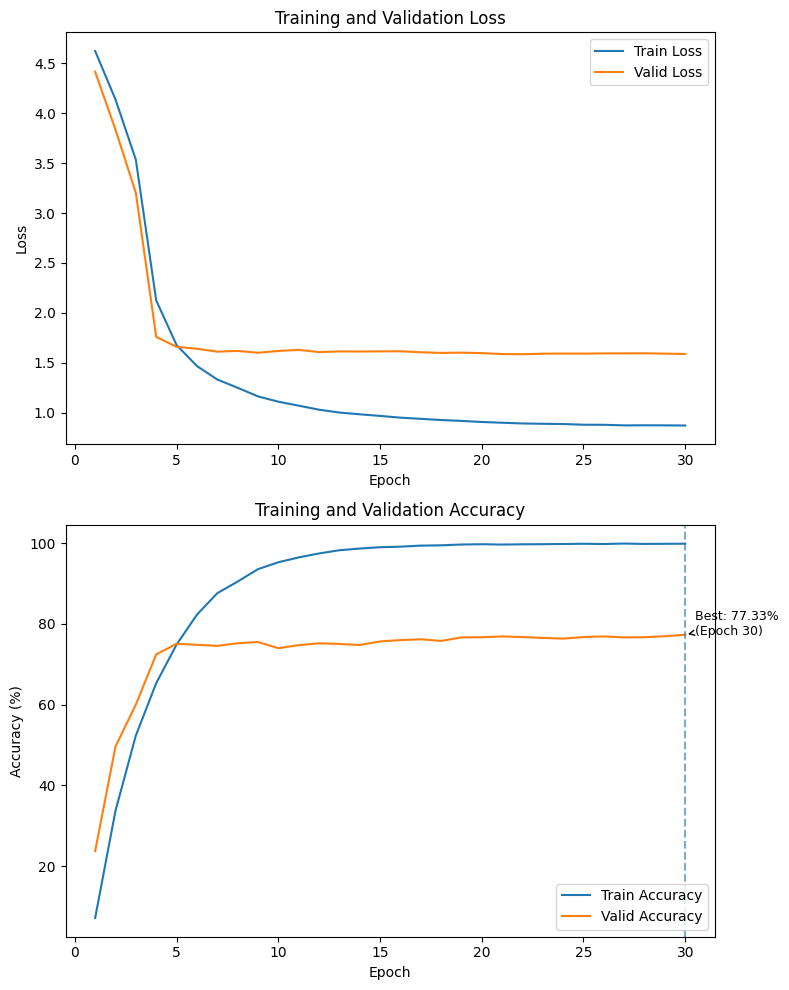

In [ ]:

# ========= Plots =========
epochs = list(range(1, len(history['train_loss'])+1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(epochs, history['train_loss'], label='Train Loss')
ax1.plot(epochs, history['val_loss'], label='Valid Loss')
ax1.set_title('Training and Validation Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()

ax2.plot(epochs, history['train_acc'], label='Train Accuracy')
ax2.plot(epochs, history['val_acc'], label='Valid Accuracy')
if metrics['best_epoch'] > 0:
    ax2.axvline(metrics['best_epoch'], linestyle='--', alpha=0.6)
    y_best = history['val_acc'][metrics['best_epoch']-1]
    ax2.annotate(f"Best: {metrics['best_val_acc']:.2f}%\n(Epoch {metrics['best_epoch']})",
                 xy=(metrics['best_epoch'], y_best), xycoords='data',
                 xytext=(metrics['best_epoch']+0.5, max(history['val_acc'])),
                 textcoords='data', arrowprops=dict(arrowstyle='->', lw=1), fontsize=9)
ax2.set_title('Training and Validation Accuracy'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy (%)'); ax2.legend(loc='lower right')

fig.tight_layout()
fig.savefig(FIG_DIR / 'training_curves.png', dpi=150)
plt.show()


In [ ]:

# ========= Save artifacts =========
torch.save(model.state_dict(), OUTPUT_DIR / 'mobilenetv2_best.pth')
with open(OUTPUT_DIR / 'mobilenetv2_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('Artifacts saved to:', OUTPUT_DIR)
print('Figures saved to:', FIG_DIR)


Artifacts saved to: artifacts_mnv2_tfds
Figures saved to: figures_mnv2_tfds
